#Questions:
- Should data augmentation not be added with transforms with original data ?
- Can the LSTM be implemented as the first layer of our model ?
- What is the best manner to fine tune the hyperparameters ?
- Should we implement an early stop in our training part ? or should we only take the best accuracy/f1 score over all epochs to evaluate or model ?


# CNN model (from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network)

## 0. Load modules


In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating System Interaction
import os
import sys

# Machine Learning Frameworks
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

# Data Transformation and Augmentation (not all of these transformations were finally used)
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, \
    RandomVerticalFlip, ColorJitter, RandomAffine, RandomPerspective, RandomResizedCrop, \
    GaussianBlur, RandomAutocontrast
from torchvision.transforms import functional as F

# Model Building and Initialization
import torch.nn as nn
from torch.nn.init import kaiming_normal_

# Data Loading and Dataset Handling
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from PIL import Image

# Cross-Validation and Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from scipy.special import expit as sigmoid

# Visualization and Display
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import HTML

# Miscellaneous
import random
from tqdm import tqdm

## 1. Import the data, create the dataset, define the Dataloaders

### 1.1 Declare data path

In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'
    folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_test'
    folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_test'
    folder0_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'
    folder1_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'

    #Adrien
    #folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    #folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    #folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    #folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'
    #folder0_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data0_val'
    #folder1_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data1_val'
else:
    # For local environments like VS Code
    folder0_path = '../data/data separated/data0'
    folder1_path = '../data/data separated/data1'
    folder0_test_path = '../data/data separated/data0_test'
    folder1_test_path = '../data/data separated/data1_test'
    folder0_valid_path = '../data/data separated/data0_val'
    folder1_valid_path = '../data/data separated/data1_val'

### 1.2 Declare the class and the transforms

In [3]:
class TensorTransforms:
    def __init__(self, rotate_angle=30):
        self.rotate_angle = rotate_angle

    def random_horizontal_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [2])  # Flip along width
        return x

    def random_vertical_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [1])  # Flip along height
        return x

    def random_rotation(self, x):
        # Random rotation in increments of 90 degrees for simplicity
        k = random.randint(0, 3)  # 0, 90, 180, or 270 degrees
        return torch.rot90(x, k, [1, 2])  # Rotate along height and width

    def __call__(self, x):
        x = self.random_horizontal_flip(x)
        x = self.random_vertical_flip(x)
        x = self.random_rotation(x)
        return x

class NPZDataset(Dataset):
    def __init__(self, data_dir, augment=True, mean=None, std=None):
        self.data_dir = data_dir
        self.augment = augment
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = TensorTransforms()
        self.mean = mean
        self.std = std

    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension

        data = torch.from_numpy(data).float()  # Convert to PyTorch tensor

        if self.augment: #way to improve is to add to the data
            data = self.transform(data) #there we should concatenate both data and data_transformed

        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        label = 1.0 if 'data1' in self.data_dir else 0.0

        return data, np.float32(label)

In [4]:
mean_data = 50.564544677734375
std_data = 49.94772720336914

### 1.3 Get the data, declare the Dataloaders

In [5]:
train_data1 = NPZDataset(folder1_path, mean=mean_data, std=std_data, augment=True)
train_data0 = NPZDataset(folder0_path, mean=mean_data, std=std_data, augment=True)
train_dataset = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, mean=mean_data, std=std_data, augment=False)
test_data0 = NPZDataset(folder0_test_path, mean=mean_data, std=std_data, augment=False)
test_dataset = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, mean=mean_data, std=std_data, augment=False)
valid_data0 = NPZDataset(folder0_valid_path, mean=mean_data, std=std_data, augment=False)
validate_dataset = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(validate_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

Visualize transforms: shows 5 images (10-15 of a sequence) of a chosen sequence in the data. The transform shown is the train_transform defined 2 cells above

In [ ]:
"""idx = 33 # index of image to visualize
sample_sequence, _ = train_data[idx]
original_sequence = np.moveaxis(sample_sequence.numpy(), 0, -1)  # Move axes back for visualization

# Display the original sequence

plt.figure(figsize=(16, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(original_sequence[:, :, 10+i], cmap='sdoaia304')
    plt.title(f'original img {i + 1}')
    plt.axis('off')

plt.suptitle('Original Sequence', fontsize=16)

# Plot the transformed sequence

plt.figure(figsize=(16, 4))
i = 0

for image in sample_sequence[10:15]:
    plt.subplot(1, 5, i + 1)
    trans = train_transform(image)
    plt.imshow(trans.squeeze(), cmap='sdoaia304')
    plt.title(f'transformed img {i + 1}')
    plt.axis('off')
    i += 1

plt.suptitle('Transformed Sequence', fontsize=16)
plt.show()"""

"idx = 33 # index of image to visualize\nsample_sequence, _ = train_data[idx]\noriginal_sequence = np.moveaxis(sample_sequence.numpy(), 0, -1)  # Move axes back for visualization\n\n# Display the original sequence\n\nplt.figure(figsize=(16, 4))\nfor i in range(5):\n    plt.subplot(1, 5, i + 1)\n    plt.imshow(original_sequence[:, :, 10+i], cmap='sdoaia304')\n    plt.title(f'original img {i + 1}')\n    plt.axis('off')\n\nplt.suptitle('Original Sequence', fontsize=16)\n\n# Plot the transformed sequence\n\nplt.figure(figsize=(16, 4))\ni = 0\n\nfor image in sample_sequence[10:15]:\n    plt.subplot(1, 5, i + 1)\n    trans = train_transform(image)\n    plt.imshow(trans.squeeze(), cmap='sdoaia304')\n    plt.title(f'transformed img {i + 1}')\n    plt.axis('off')\n    i += 1\n\nplt.suptitle('Transformed Sequence', fontsize=16)\nplt.show()"

## 2. Define the RCNN, the predict and test functions

In [ ]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # hidden_size is an hyperparameter to be adjusted
        # try augmenting num_layers
        self.lstm = nn.LSTM(input_size=12800, hidden_size=256, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(32,1),
            #nn.Sigmoid()     # don't include it as it is already included in BCELogitLoss (BCELoss is less stable)
        )

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

In [ ]:
def predict(model, train_loader, criterion, device, threshold):
    model.eval()
    correct, val_loss, total_length = 0, 0, 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in train_loader:

            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float()

            # PERFORMANCE CALCULATION
            val_loss += loss.item() * len(data)
            total_length += len(data)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    val_loss = val_loss / total_length
    val_acc = correct / total_length

    return val_loss, val_acc, np.array(all_preds), np.array(all_targets)


def test(model, train_loader, criterion, device, threshold):
    model.eval()
    correct, val_loss, total_length = 0, 0, 0
    all_preds = []
    all_targets = []
    all_out = []
    f1 = []

    with torch.no_grad():
        for data, target in train_loader:

            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float()

            # PERFORMANCE CALCULATION
            val_loss += loss.item() * len(data)
            total_length += len(data)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())
            all_out.extend(output.view(-1).cpu().numpy())

    val_loss = val_loss / total_length
    val_acc = correct / total_length

    return val_loss, val_acc, np.array(all_preds), np.array(all_targets), np.array(all_out)

## 3. Import the trained models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'google.colab' in sys.modules:
    from google.colab import drive
    #drive.mount('/content/drive')
    model_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/Trained_RCNN.pth'
    model2_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/Trained_RCNN_2.pth'
else:
  model_path = './Trained_RCNN.pth'
  model2_path = './Trained_RCNN_2.pth'

model = torch.load(model_path, map_location=device)
model2 = torch.load(model2_path, map_location=device)

model.eval()
model2.eval()

model = model.to(device)
model2 = model2.to(device)

## 4. F1 score vs threshold

In [ ]:
thresholds = np.linspace(0, 1, 100)
criterion = torch.nn.BCEWithLogitsLoss()
print(device)

""" Model 1 """

model_f1 = np.zeros(len(thresholds))
model_acc = np.zeros(len(thresholds))

for i,t in enumerate(thresholds):
    _, acc, pred, target, _ = test(model, valid_loader, criterion, device, t)
    f1 = f1_score(target, pred, average='binary')
    print(f"model 1, f1 = {f1}, acc = {acc} \n")
    model_f1[i] = f1
    model_acc[i] = acc



""" Model 2 """

model2_f1 = np.zeros(len(thresholds))
model2_acc = np.zeros(len(thresholds))

for i,t in enumerate(thresholds):
    _, acc, pred, target, _ = test(model2, valid_loader, criterion, device, t)
    f1 = f1_score(target, pred, average='binary')
    print(f"model 2, threshold:  {i}, f1 = {f1}, acc = {acc} \n")
    model2_f1[i] = f1
    model2_acc[i] = acc


cuda
model 1, f1 = 0.6666666666666666, acc = 0.5 

model 1, f1 = 0.8395904436860069, acc = 0.8134920634920635 

model 1, f1 = 0.8602150537634408, acc = 0.8452380952380952 

model 1, f1 = 0.8717948717948718, acc = 0.8611111111111112 

model 1, f1 = 0.8847583643122676, acc = 0.876984126984127 

model 1, f1 = 0.8838951310861424, acc = 0.876984126984127 

model 1, f1 = 0.887218045112782, acc = 0.8809523809523809 

model 1, f1 = 0.8905660377358492, acc = 0.8849206349206349 

model 1, f1 = 0.8939393939393939, acc = 0.8888888888888888 

model 1, f1 = 0.8897338403041825, acc = 0.8849206349206349 



KeyboardInterrupt: ignored

In [ ]:
best_idx1 = np.argmax(model_f1)
best_idx2 = np.argmax(model2_f1)

print(f"The higher F1-score of model 1 is {model_f1[best_idx1]} and corresponds to a threshold value of {thresholds[best_idx1]:.4}. \n ")
print(f"The higher F1-score of model 2 is {model2_f1[best_idx2]} and corresponds to a threshold value of {thresholds[best_idx2]:.4}. \n ")


The higher F1-score of model 1 is 0.8968253968253969 and corresponds to a threshold value of 0.2727. 
 
The higher F1-score of model 2 is 0.8634686346863469 and corresponds to a threshold value of 0.1616. 
 


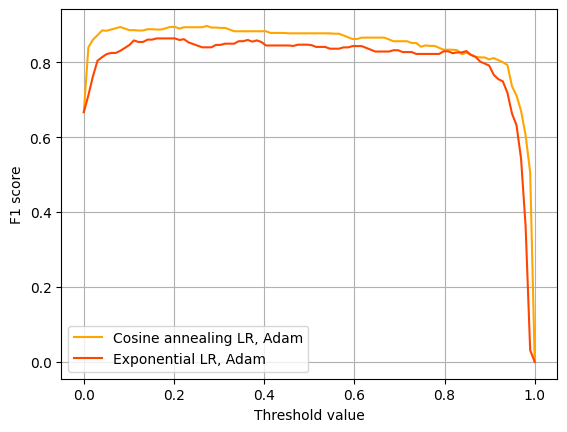

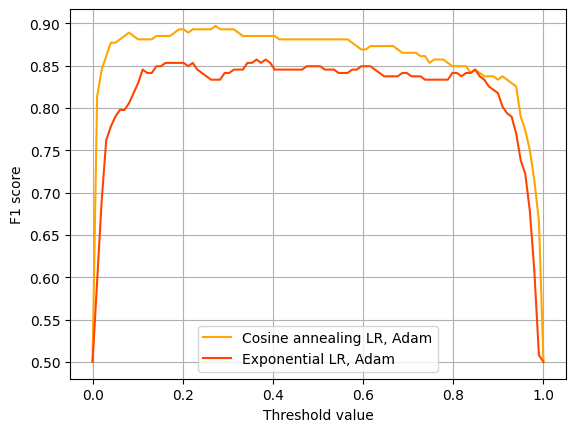

In [ ]:
""" 1 subfigure """

fig, axs = plt.subplots()

axs.plot(thresholds, model_f1, color='orange', label='Cosine annealing LR, Adam')
axs.plot(thresholds, model2_f1, color='orangered', label='Exponential LR, Adam')

axs.set_xlabel('Threshold value')
axs.set_ylabel('F1 score')
axs.grid(True)
axs.legend()

fig.savefig('f1_vs_threshold.eps', format='eps')


""" 1 subfigure """

fig2, axs2 = plt.subplots()

axs2.plot(thresholds, model_acc, color='orange', label='Cosine annealing LR, Adam')
axs2.plot(thresholds, model2_acc, color='orangered', label='Exponential LR, Adam')

axs2.set_xlabel('Threshold value')
axs2.set_ylabel('F1 score')
axs2.grid(True)
axs2.legend()

## 5. Define, run and analyze best model (on test set now that this model is the final version!!)

In [ ]:
best_model = model
best_thres = 0.27
criterion = torch.nn.BCEWithLogitsLoss()

loss, accuracy, pred, target, _ = test(best_model, test_loader, criterion, device, best_thres)
test_f1 = f1_score(target, pred, average='binary')

In [ ]:
print(f"Accuracy of the model on the test set: {accuracy:.4} \n")
print(f"Loss of the model on the test set: {loss:.4} \n")
print(f"F1 score on test set: {test_f1:.4}")

Accuracy of the model on the test set: 0.9308 

Loss of the model on the test set: 0.1901 

F1 score on test set: 0.9338


## 5.1 Confusion matrix

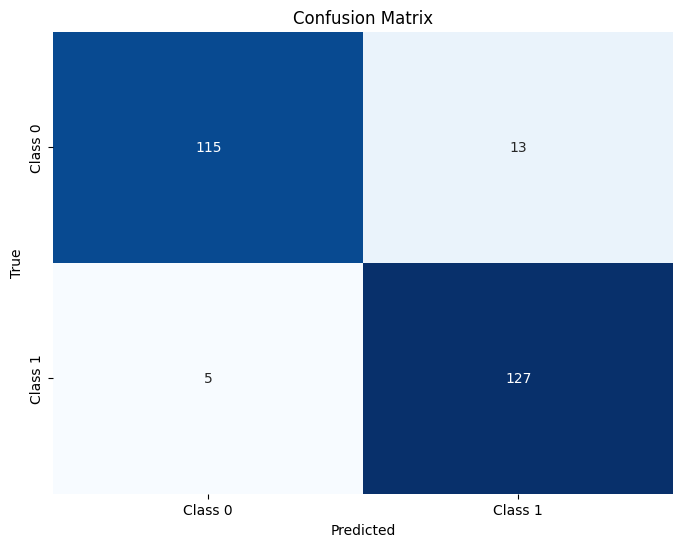

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(target, pred)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## 5.2 Misclassified images

In [ ]:
!pip install sunpy
import sunpy

from torchvision import transforms
import sunpy.visualization.colormaps as cm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.8 MB/s eta 0:00:00


In [ ]:
# Set the model to evaluation mode
model = model.to(device)
threshold = 0.27

misclassified_images = []
true_labels = []
predicted_labels = []

count=0
itera=0
# Iterate through the test set
with torch.no_grad():
        for data, target in test_loader:
            itera+=1
            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float().view(-1).cpu()
            target=target.view(-1).cpu()

            # Identify misclassified images
            misclassified_mask = pred != target
            count+=misclassified_mask.sum()

            if misclassified_mask.sum()>0:
                 for predict, targ in zip(pred, target):
                      if predict.item()==0 and targ.item()==1: #Get the false negative
                           print(f"{itera*2}") #Batchsize
            #print(target)
            #print(pred)
            #print(misclassified_mask)
            misclassified_images.extend(data[misclassified_mask])
            true_labels.extend(target[misclassified_mask])
            predicted_labels.extend(pred[misclassified_mask])

print(f"There is {count} missclassified images")
# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])



6
26
30
32
62
There is 18 missclassified images


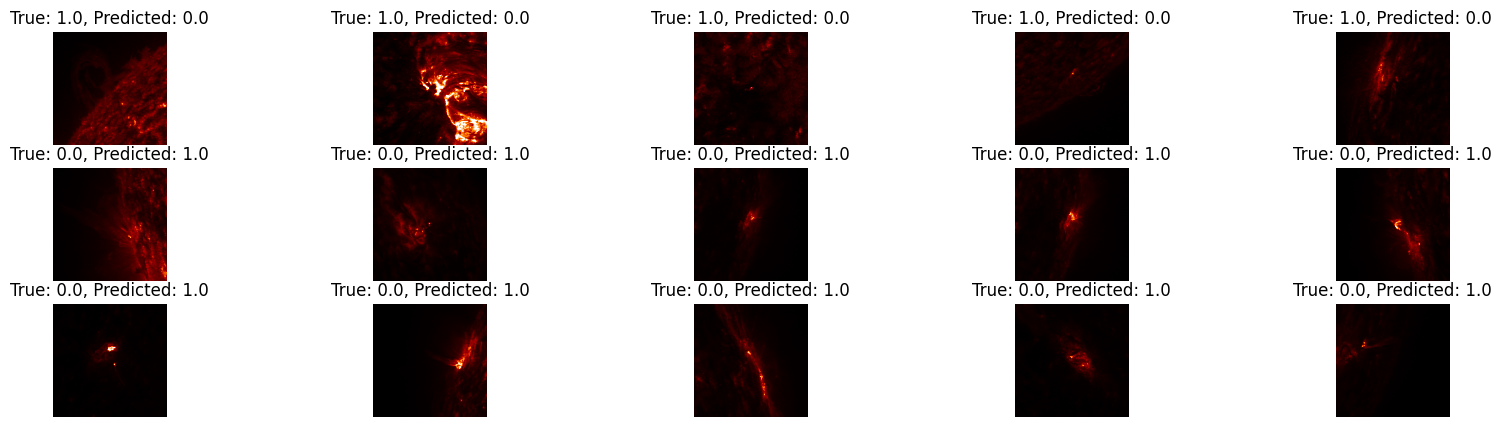

In [ ]:

# Display misclassified images
num_images_to_display = min(15, len(misclassified_images))
fig, axes = plt.subplots(num_images_to_display//5, 5, figsize=(20,5))

for i in range(num_images_to_display):
    row = i // 5
    column = i - row*5
    image = reverse_normalize(misclassified_images[i]).cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    axes[row, column].imshow(image[15,:,:], cmap='sdoaia304')
    axes[row, column].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[row, column].axis('off')

plt.show()
